In [112]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', 500)

C:\Users\Florian\Anaconda3\envs\data-x\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


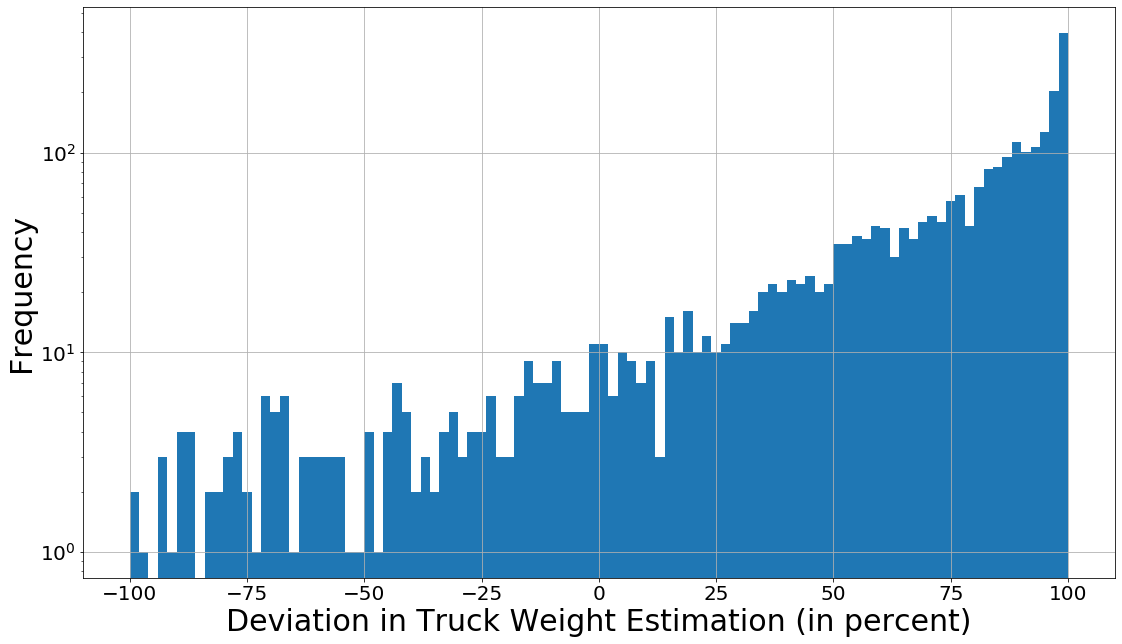

In [294]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import re

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

data = pd.read_csv("C:/Users/Florian/projects/Travelers/friday_sprint/matching/20220121-182906_matching_table.csv")

# Data for dumpster loads only
truck_mask = (data["subcategory_prev"] == "GENERAL DEMOLITION") & data["item_description"].str.contains("DUMPSTER LOAD")
truck_data = data[truck_mask].copy()

pickup_mask = (data["subcategory_prev"] == "GENERAL DEMOLITION") & data["item_description"].str.contains("HAUL DEBRIS - PER PICKUP TRUCK LOAD")
pickup_data = data[pickup_mask].copy()

# Mask for items associated with valid pentatonic IDs
id_matched_mask = data["pentatonic_id"].notna() & (data["pentatonic_id"] != "")

data["weight_lbs"] = data["weight_lbs"].astype('str').str.replace(',', '.')
data["weight_ustons"] = data["weight_ustons"].astype('str').str.replace(',', '.')
data["volume_cf"] = data["volume_cf"].astype('str').str.replace(',', '.')
data["volume_cy"] = data["volume_cy"].astype('str').str.replace(',', '.')
data["item_quantity"] = data["item_quantity"].astype('str').str.replace(',', '.')

# Estimated weight of claim items
data["item_weight_lbs"] = data["weight_lbs"].astype('float') * data["item_quantity"].astype('float')
data["item_weight_ustons"] = data["weight_ustons"].astype('float') * data["item_quantity"].astype('float')
data["item_volume_cf"] = data["volume_cf"].astype('float') * data["item_quantity"].astype('float')
data["item_volume_cy"] = data["volume_cy"].astype('float') * data["item_quantity"].astype('float')

# Dumpster load items have patterns, e.g. "DUMPSTER LOAD APPROX 12 YARDS 1-3 TONS DEBRIS" or DUMPSTER LOAD APPROX 20 YARDS 4 TONS DEBRIS
# In order to calculate weight for each truck, numbers before TONS are extracted

# Mask for items with ranged numbers, such as 1-3 TONS, 5-7 TONS, etc. 
range_mask = truck_data["item_description"].str.contains('\s+\d\s*-\s*\d\s+TONS', flags=re.IGNORECASE, regex=True)

# Mask for items with exact numbers, such as 4 TONS, etc. 
precise_mask = truck_data["item_description"].str.contains('(\s+\d\s+TONS)(?!\s+\d\s*-\s*\d\s+TONS)', flags=re.IGNORECASE, regex=True)

# Since for majority of trucks range of weights is given, the corresponding columns are introduced
# In case of single number, lower and upper weights are the same
truck_data[["lower_truck_weight", "upper_truck_weight"]] = 0
truck_data.loc[range_mask, ["lower_truck_weight", "upper_truck_weight"]] = truck_data.loc[range_mask, "item_description"].str.extract(r'\s+(\d)\s*-\s*(\d)\s+TONS', flags=re.IGNORECASE).values
truck_data.loc[precise_mask, "lower_truck_weight"] = truck_data.loc[precise_mask, "upper_truck_weight"] = truck_data.loc[precise_mask, "item_description"].str.extract(r'\s+(\d)\s+TONS', flags=re.IGNORECASE).values

# Calculate average weight for each truck and mulptiply by number of trucks
truck_data["average_truck_weight"] = 0.5*(truck_data["lower_truck_weight"].astype(float) + truck_data["upper_truck_weight"].astype(float))*truck_data["item_quantity"]

pickup_data['weight'] = pickup_data['item_quantity'] * 2.4 #assumptions based on data we got for our app

# Total weight of all trucks per claim ID
truck_weight_data = truck_data.groupby("claim_id").agg(total_truck_weight=("average_truck_weight", "sum")).reset_index()

pickup_weight_data = pickup_data.groupby("claim_id").agg(total_pickup_weight=("weight", "sum")).reset_index()

all_truck_weight_data = pd.merge(truck_weight_data, pickup_weight_data, how='outer')

all_truck_weight_data['total_pickup_weight'] = all_truck_weight_data['total_pickup_weight'].fillna(0)
all_truck_weight_data['total_truck_weight'] = all_truck_weight_data['total_truck_weight'].fillna(0)

all_truck_weight_data['all_truck_weight'] = all_truck_weight_data['total_truck_weight'] + all_truck_weight_data['total_pickup_weight']

# Merge total weight truck data with main claim data
data = data.merge(all_truck_weight_data[["claim_id", "all_truck_weight"]], on="claim_id", how="left")

truck_mask = truck_mask | pickup_mask

# Function to calculate fraction of items matched with weights DB
def matching_fraction(col):
    
    mask = col.notna() & (col != 0) & (col != "")
    
    return round(mask.sum()/col.shape[0], 2)

# Aggregate claim data for each claim ID
claim_id_data = data[~truck_mask].groupby(["claim_id"]).agg(
    total_claims=("item_description", "count"),
    total_items=("item_quantity", "sum"), #changed from item_quantity to count
    all_truck_weight=("all_truck_weight", "last"),
    weight_estimation_lbs=("item_weight_lbs", "sum"),
    weight_estimation_ustons=("item_weight_ustons", "sum"),
    volume_estimation_cf=("item_volume_cf", "sum"),
    volume_estimation_cy=("item_volume_cy", "sum"),
    ID_matched_fraction=("pentatonic_id", matching_fraction),
    matched_fraction=("item_weight_lbs", matching_fraction)
)

#claim_id_data.to_csv(("data/output/count_temp_save.csv"))

# Calculate difference between total truck weight and total estimated weight of claims in US tonnes
claim_id_data["excessive_truck_weight"] = claim_id_data["all_truck_weight"].astype('float') - claim_id_data["weight_estimation_ustons"].astype('float')
claim_id_data["excessive_truck_weight_percentage"] = claim_id_data["excessive_truck_weight"]/claim_id_data["all_truck_weight"]*100
claim_id_data["abs_excessive_truck_weight_percentage"] = claim_id_data["excessive_truck_weight_percentage"].abs()


# Saving data to Excel
claim_id_data.to_excel(("friday_sprint/results/" + timestr +  "_claim_id_weight_comparison.xlsx"))

plot = claim_id_data["excessive_truck_weight_percentage"].hist(bins=100, range=(-100, 100), grid=True)

plt.xlabel('Deviation in Truck Weight Estimation (in percent)', fontsize=30)
plt.ylabel('Frequency', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.savefig("friday_sprint/results/" + timestr + "_truck_weight_frequency.png")

plt.yscale("log")

plt.savefig("friday_sprint/results/" + timestr + "_truck_weight_frequency_log.png")

#calculate metrics
valid_calc_mask = claim_id_data['excessive_truck_weight'].isna() == False
valid_claim_id_data = claim_id_data[valid_calc_mask]

claims_with_weight = len(claim_id_data[valid_calc_mask])
average_deviation = claim_id_data["abs_excessive_truck_weight_percentage"].mean()
min_deviation = claim_id_data["excessive_truck_weight_percentage"].min()
max_deviation = claim_id_data["excessive_truck_weight_percentage"].max()

negative_mask = valid_claim_id_data['excessive_truck_weight_percentage'] < 0
positive_mask = valid_claim_id_data['excessive_truck_weight_percentage'] > 0
ten_percent_off_mask = valid_claim_id_data['abs_excessive_truck_weight_percentage'] < 10
ten_percent_saving_mask = (valid_claim_id_data['excessive_truck_weight_percentage'] > 0) & (valid_claim_id_data['excessive_truck_weight_percentage'] <= 10)
twenty_percent_saving_mask = (valid_claim_id_data['excessive_truck_weight_percentage'] > 0) & (valid_claim_id_data['excessive_truck_weight_percentage'] <= 20)
fifty_percent_saving_mask = (valid_claim_id_data['excessive_truck_weight_percentage'] > 0) & (valid_claim_id_data['excessive_truck_weight_percentage'] <= 50)

ten_percent_est = len(valid_claim_id_data[ten_percent_saving_mask])
negative_est = len(valid_claim_id_data[negative_mask]) # so we overestimate
negative_est_average = valid_claim_id_data.loc[negative_mask, 'excessive_truck_weight_percentage'].mean()
positive_est = len(valid_claim_id_data[positive_mask]) # so we overestimate
positive_est_average = valid_claim_id_data.loc[positive_mask, 'excessive_truck_weight_percentage'].mean()
ten_percent_saving_est = len(valid_claim_id_data[ten_percent_saving_mask])
twenty_percent_saving_est = len(valid_claim_id_data[twenty_percent_saving_mask])
fifty_percent_saving_est = len(valid_claim_id_data[fifty_percent_saving_mask])

lines = ['Total Claims with weight information:' + str(claims_with_weight),
         '\nClaims that are within 10% deviation from given weight: ' + str(ten_percent_saving_est),
         '\nOverall Average Deviation (in %): ' + str(average_deviation),
         '\nMin Deviation (in %): '+ str(min_deviation),
         '\nMax Deviation (in %): '+ str(max_deviation),
         '\n-----------------------------------------------',
         '\nNEGATIVE: We overestimate',
         '\nNumber of overestimated claims: ' + str(negative_est),
         '\nAverage Overestimation (in %): ' + str(negative_est_average),
         '\n-----------------------------------------------',
         '\nPOSTIVE: We underestimate (either not enough matches or a saving)',
         '\nNumber of overestimated claims: ' + str(positive_est),
         '\nAverage Overestimation (in %): ' + str(positive_est_average),
         '\n-------------------------------------------------',
         '\nPotential business savings:',
         '\nClaims with up to 10% saving in weight: ' + str(ten_percent_saving_est),
         '\nClaims with up to 20% saving in weight: ' + str(twenty_percent_saving_est),
         '\nClaims with up to 50% saving in weight: ' + str(fifty_percent_saving_est)
        ]
#with open("friday_sprint/results/" + timestr + "_metrics.txt", 'w') as f:
#    f.writelines(lines)
    
with open("friday_sprint/results/" + timestr + "_metrics.txt", mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(lines))

In [271]:
twenty_percent_saving_mask = (valid_claim_id_data['excessive_truck_weight_percentage'] > 90) & (valid_claim_id_data['excessive_truck_weight_percentage'] <= 100)

In [272]:
valid_claim_id_data[twenty_percent_saving_mask].sort_values(by='excessive_truck_weight', ascending=False)

,total_claims,total_items,all_truck_weight,weight_estimation_lbs,weight_estimation_ustons,volume_estimation_cf,volume_estimation_cy,ID_matched_fraction,matched_fraction,excessive_truck_weight,excessive_truck_weight_percentage,abs_excessive_truck_weight_percentage
claim_id,,,,,,,,,,,,
8227,10,1.011.751.014.048.0160.014.0200.014.018.0,32.00,0.476145,0.476145,0.0,0.0,0.30,1.00,31.523855,98.512048,98.512048
1074,9,400.0480.0325.04.02.02.0200.020.0400.0,22.50,1.204987,1.204987,0.0,0.0,0.78,0.89,21.295013,94.644500,94.644500
1595,10,1.01.02960.03.060.076.074.672.01.0208.0,23.00,2.268482,2.268482,0.0,0.0,0.60,1.00,20.731518,90.137035,90.137035
2938,7,9.511.386.510.332.0371.0600000000002270.13,16.00,0.553680,0.553680,0.0,0.0,0.71,1.00,15.446320,96.539497,96.539497
440,1,1000.0,15.00,0.000000,0.000000,0.0,0.0,0.00,0.00,15.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10149,1,28.0,0.72,0.005600,0.005600,0.0,0.0,1.00,1.00,0.714400,99.222222,99.222222
8673,2,15.010.0,0.60,0.002250,0.002250,0.0,0.0,0.00,0.50,0.597750,99.625000,99.625000
4536,1,4.0,0.40,0.001128,0.001128,0.0,0.0,1.00,1.00,0.398872,99.717917,99.717917


In [298]:
result = data[data['claim_id'] == 1058][['claim_id', 'item_description', 'item_unit_cd', 'item_quantity', 'weights_primary_desc', 'unit', 'weight_lbs']]
result['product'] = result['item_quantity'].astype('float') * result['weight_lbs'].astype('float')
print(result['product'].sum())
result

202565.54125


,claim_id,item_description,item_unit_cd,item_quantity,weights_primary_desc,unit,weight_lbs,product
4485,1058,"1/2"" DRYWALL - HUNG, TAPED, READY FOR TEXTURE",SF,64.0,Drywall,SF,0.0,0.00000
4486,1058,MASK PER SQUARE FOOT FOR DRYWALL WORK,SF,177.35,Drywall,NaN,2.475,438.94125
4487,1058,TEXTURE DRYWALL - MACHINE,SF,64.0,"Automobile,Drywall",NaN,0.0,0.00000
4488,1058,"BUILDER BOARD - 1/2"" (COMPOSITION OR FIBERBOAR...",SF,4710.0,"Composition,Framing,Sheathing",NaN,41.5,195465.00000
4489,1058,"DUMPSTER LOAD - APPROX. 12 YARDS, 1-3 TONS OF ...",EA,1.0,NaN,NaN,0.0,0.00000
4490,1058,"BATT INSULATION - 10"" - R30 - PAPER / FOIL FACED",SF,64.0,"Insulation,Roll Insulation; Batt Insulation",SF,0.4,25.60000
4491,1058,"INSULATION - ISO BOARD, 1""",SQ,15.7,"Insulation,Roofing",SQ,24.0,376.80000
4492,1058,"INSULATION - ISO BOARD, 2""",SQ,15.7,"Insulation,Roofing",SQ,40.0,628.00000
4493,1058,MEMBRANE ROOFING - CANT STRIPS - PERLITE,LF,270.0,"Roofing,Membrane",NaN,0.0,0.00000
4494,1058,SINGLE PLY MEMBRANE - FULLY ADHERED SYSTEM - 6...,SQ,33.09,"Roofing,Membrane",SQ,40.0,1323.60000


In [287]:
data[data['claim_id'] == 8227]

,Unnamed: 0,claim_id,subcategory_prev,item_description,div_cd,ls_date,nol_date,zip,reason,primary_col_desc,item_unit_cd,item_quantity,count,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,primary_city,state,county,category,subcategory,pentatonic_id,weights_primary_desc,unit,unit_matching,weight_ustons_max_max,weight_ustons_mean_mean,weight_ustons_median_median,weight_ustons_min_min,weight_ustons_max_zero,weight_ustons_mean_zero,weight_ustons_median_zero,weight_ustons_min_zero,weights_ustons,weight_ustons,weight_lbs,volume_cf,volume_cy,item_weight_lbs,item_weight_ustons,item_volume_cf,item_volume_cy,all_truck_weight
27130,68249,8227,DOORS,OVERHEAD DOOR & HARDWARE - 8' X 7',PI,202008,202008,77632,Wind,Wind,EA,1.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Construction/Demolition Waste,Doors,NaN,"Door,Doors",NaN,undefined,0.065000,0.033228,0.027558,0.016535,0.000000,0.000000,0.000000,0.000000,0.027558,0.02755775,55.1155,nan,nan,55.115500,0.027558,NaN,NaN,32.0
27131,68250,8227,DRYWALL,DRYWALL TAPE JOINT/REPAIR - PER LF,PI,202008,202008,77632,Wind,Wind,LF,11.75,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Construction/Demolition Waste,Drywall,NaN,Drywall,NaN,undefined,0.004400,0.002850,0.002700,0.001600,0.000000,0.000000,0.000000,0.000000,0.002700,0.0027,5.4,nan,nan,63.450000,0.031725,NaN,NaN,32.0
27132,68251,8227,EXTERIOR STRUCTURES,STORAGE SHED - METAL - BARN TYPE (GAMBREL) - 1...,PI,202008,202008,77632,Wind,Wind,EA,1.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Metals,Metal,NaN,Sheds,NaN,undefined,0.055115,0.055115,0.055115,0.055115,0.000000,0.000000,0.000000,0.000000,0.055115,0.0551155,110.23100000000001,nan,nan,110.231000,0.055115,NaN,NaN,32.0
27133,68252,8227,FRAMING & ROUGH CARPENTRY,"1"" X 4"" LUMBER (.333 BF PER LF)",PI,202008,202008,77632,Wind,Wind,LF,14.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Construction/Demolition Waste,Carpentry,NEW0044,"Framing,Lumber",LF,yes,0.000310,0.000310,0.000310,0.000310,0.000310,0.000310,0.000310,0.000310,0.000310,0.00031,0.62,nan,nan,8.680000,0.004340,NaN,NaN,32.0
27134,68253,8227,GENERAL DEMOLITION,HAUL DEBRIS - PER PICKUP TRUCK LOAD - INCLUDIN...,PI,202008,202008,77632,Wind,Wind,EA,8.0,8,NaN,NaN,NaN,NaN,Orange,TX,Orange County,NaN,NaN,VAN0001,Van; Truck; SUV,EA,yes,1.925000,1.925000,1.925000,1.925000,1.925000,1.925000,1.925000,1.925000,1.925000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,32.0
27135,68254,8227,ROOFING,ALUMINUM CORRUGATED SHEET ROOFING - .019,PI,202008,202008,77632,Wind,Wind,SF,48.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Metals,Aluminum,NaN,"Roofing,Sheet",NaN,undefined,0.009500,0.003200,0.002000,0.000500,0.000000,0.000000,0.000000,0.000000,0.002000,0.002,4.0,nan,nan,192.000000,0.096000,NaN,NaN,32.0
27136,68255,8227,ROOFING,"METAL ROOFING - RIBBED - 26 GAUGE - UP TO 1""",PI,202008,202008,77632,Wind,Wind,SF,160.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Metals,Metal,NEW0221,"Roofing,Metal Roofing",SF,yes,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.0005,1.0,nan,nan,160.000000,0.080000,NaN,NaN,32.0
27137,68256,8227,ROOFING,RIDGE CAP - METAL ROOFING,PI,202008,202008,77632,Wind,Wind,LF,14.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,Metals,Metal,NEW0029,"Roofing,Cap,Ridge Cap,Metal Roofing",LF,yes,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,3.116666666666667e-05,0.06233333333333334,nan,nan,0.872667,0.000436,NaN,NaN,32.0
27138,68257,8227,SIDING,SIDING - ALUMINUM (.024 THICKNESS),PI,202008,202008,77632,Wind,Wind,SF,200.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,"Construction/Demolition Waste,Metals","Siding,Aluminum",NaN,Siding,NaN,undefined,0.005000,0.001241,0.000875,0.000125,0.000000,0.000000,0.000000,0.000000,0.000875,0.000875,1.75,nan,nan,350.000000,0.175000,NaN,NaN,32.0
27139,68258,8227,"SOFFIT, FASCIA, & GUTTER","FASCIA - METAL - 10""",PI,202008,202008,77632,Wind,Wind,LF,14.0,1,NaN,NaN,NaN,NaN,Orange,TX,Orange County,"Construction/Demolition Waste,Metals","Gutter,Metal",NaN,Gutters; Drip edge,NaN,und